In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import seaborn as sns
from statsmodels.api import tsa 

In [3]:
# LCL_chunk = pd.read_csv('LCL_Full/CC_LCL-FullData.csv', parse_dates=[2], infer_datetime_format=True, chunksize= 1000000)
# limit = 10
# while limit == 10:
#     for chunk in LCL_chunk:
#         print(chunk.info())
#         limit -= 1

In [4]:
# Load the power consumption data
LCL = pd.read_csv('data/CC_LCL-FullData.csv', parse_dates=[2], infer_datetime_format = True, nrows = 10000000) # Convert to DateTime format as data is read

# Load ACORN rating data
acorn = pd.read_csv('data/household_info.csv')

In [5]:
LCL.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC000002,Std,2012-10-12 00:30:00,0
1,MAC000002,Std,2012-10-12 01:00:00,0
2,MAC000002,Std,2012-10-12 01:30:00,0
3,MAC000002,Std,2012-10-12 02:00:00,0
4,MAC000002,Std,2012-10-12 02:30:00,0


In [6]:
# Rename columns
LCL.rename(columns = {'LCLid': 'id',
                     'stdorToU': 'tariff',
                     'DateTime':'timestamp',
                     'KWH/hh (per half hour) ':'power'}, inplace = True)

# Check renamed
LCL.columns

Index(['id', 'tariff', 'timestamp', 'power'], dtype='object')

In [7]:
# Check data types
LCL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   id         object        
 1   tariff     object        
 2   timestamp  datetime64[ns]
 3   power      object        
dtypes: datetime64[ns](1), object(3)
memory usage: 305.2+ MB


In [8]:
# Data contained null values but as a string. Convert these to numerical nulls.
LCL['power'].loc[LCL['power'] == 'Null'] = np.nan
LCL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   id         object        
 1   tariff     object        
 2   timestamp  datetime64[ns]
 3   power      object        
dtypes: datetime64[ns](1), object(3)
memory usage: 305.2+ MB


C:\Users\triha\AppData\Local\Temp\ipykernel_19244\1019508354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LCL['power'].loc[LCL['power'] == 'Null'] = np.nan


In [9]:
LCL[LCL.duplicated()].sort_values(by = ['power', 'timestamp'])

,id,tariff,timestamp,power
1023244,MAC000037,Std,2011-12-15,0
5918825,MAC000197,Std,2011-12-15,0
601955,MAC000025,Std,2012-01-15,0
1024733,MAC000037,Std,2012-01-15,0
5920314,MAC000197,Std,2012-01-15,0
...,...,...,...,...
941822,MAC000034,Std,2013-12-28,4.7719998
944800,MAC000034,Std,2014-02-28,5.6900001
928425,MAC000034,Std,2013-03-24,5.7870002
926936,MAC000034,Std,2013-02-21,6.0830002


In [10]:
LCL['day'] = LCL['timestamp'].dt.date

In [11]:
LCL.head()

,id,tariff,timestamp,power,day
0,MAC000002,Std,2012-10-12 00:30:00,0,2012-10-12
1,MAC000002,Std,2012-10-12 01:00:00,0,2012-10-12
2,MAC000002,Std,2012-10-12 01:30:00,0,2012-10-12
3,MAC000002,Std,2012-10-12 02:00:00,0,2012-10-12
4,MAC000002,Std,2012-10-12 02:30:00,0,2012-10-12


In [12]:
LCL.drop_duplicates(inplace = True)
LCL.reset_index(inplace = True, drop = True)

In [13]:
LCL.power = 0.5*LCL.power.astype('float') # Convert to float, then convert units to KW instead of KWh/hh

In [14]:
LCL = LCL.join(acorn[['LCLid', 'Acorn_grouped']].set_index('LCLid'), on = 'id') # Join Acorn affluence data

In [15]:
LCL.head()

,id,tariff,timestamp,power,day,Acorn_grouped
0,MAC000002,Std,2012-10-12 00:30:00,0.0,2012-10-12,Affluent
1,MAC000002,Std,2012-10-12 01:00:00,0.0,2012-10-12,Affluent
2,MAC000002,Std,2012-10-12 01:30:00,0.0,2012-10-12,Affluent
3,MAC000002,Std,2012-10-12 02:00:00,0.0,2012-10-12,Affluent
4,MAC000002,Std,2012-10-12 02:30:00,0.0,2012-10-12,Affluent


In [16]:
LCL.rename(columns = {"power":"KW", "Acorn_grouped": "acorn"}, inplace=True) # Rename columns.
LCL.drop(columns = ['id'], inplace=True) # Model will predict based on Acorn affluence, so household identifier is irrelevant once Acorn data has been joined.
LCL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9993144 entries, 0 to 9993143
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   tariff     object        
 1   timestamp  datetime64[ns]
 2   KW         float64       
 3   day        object        
 4   acorn      object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 381.2+ MB


In [17]:
LCL.acorn.value_counts()

Affluent       4123247
Comfortable    3013899
Adversity      2778151
ACORN-U          77847
Name: acorn, dtype: int64

In [18]:
# Drop rows where acorn value is not either 'Affluent', 'Comfortable', or 'Adversity'
to_keep = LCL.acorn.isin(['Affluent', 'Comfortable', 'Adversity'])
LCL = LCL[to_keep]

In [19]:
# Average energy over week for each household
# ac_grouped = (LCL[['tariff', 'day', 'KW', 'acorn']].groupby(['tariff', 'acorn', 'day']).mean()).sort_values(by = ['acorn', 'day'])
tariff_grouped = (LCL[['tariff', 'day', 'KW', 'acorn']].groupby(['tariff', 'day']).mean()).sort_values(by = ['tariff', 'day'])

In [20]:
# ac_grouped.head()
tariff_grouped.head()

KW
tariff day                 
Std    2011-11-23  0.148062
       2011-11-24  0.122387
       2011-11-25  0.115716
       2011-11-26  0.126168
       2011-11-27  0.118453

In [21]:
tariff_dt = tariff_grouped.unstack().T
tariff_dt.head()



tariff              Std
   day                 
KW 2011-11-23  0.148062
   2011-11-24  0.122387
   2011-11-25  0.115716
   2011-11-26  0.126168
   2011-11-27  0.118453

In [22]:
# https://stackoverflow.com/questions/28140771/select-only-one-index-of-multiindex-dataframe

tariff_dt.set_index(tariff_dt.index.get_level_values(1), inplace = True)
# backup = tariff_dt.copy()
# tariff_dt.columns = [f'{i}_{j}' for i,j in tariff_dt.columns] # https://stackoverflow.com/questions/24290297/pandas-dataframe-with-multiindex-column-merge-levels

In [23]:
fig = px.line(tariff_dt, x=tariff_dt.index, y=tariff_dt.columns)

fig.update_layout(
    yaxis_title="Average Power (KW)", 
    xaxis_title="Date",
    legend_title="Tariff", 
    title="Power Usage of Different Tariffs Between 2011 and 2014",
    height= 800
    
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

In [24]:
# Check for missing samples
first = tariff_dt.index.min()
last = tariff_dt.index.max()
full_range = pd.date_range(start = first, end = last, freq = 'D')
full_range.difference(tariff_dt.index)


DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [25]:
# Apply DateTime Index
tariff_dt = tariff_dt.reindex(full_range)

In [26]:
# Check nulls
tariff_dt.isna().sum()

tariff
Std    0
dtype: int64

In [27]:
tariff_decomps = pd.DataFrame()
for col in tariff_dt.columns:
    name = col + '_Decomp'
    globals()[name] = tsa.seasonal_decompose(tariff_dt[[col]], model = 'multiplicative', period = 30)
    tariff_decomps[col + '_Trend'] = globals()[name].trend
    tariff_decomps[col + '_Seasonal'] = globals()[name].seasonal
    tariff_decomps[col + '_Residual'] = globals()[name].resid

In [28]:
tariff_decomps.head()

,Std_Trend,Std_Seasonal,Std_Residual
2011-11-23,NaN,0.993013,NaN
2011-11-24,NaN,1.001433,NaN
2011-11-25,NaN,0.997541,NaN
2011-11-26,NaN,0.991179,NaN
2011-11-27,NaN,0.988679,NaN


In [29]:
fig = px.line(x = tariff_dt.index, y = tariff_decomps.Std_Trend)
fig.update_xaxes(rangeslider_visible=True)

In [30]:
fig = px.line(x = tariff_dt.index, y = tariff_decomps.Std_Seasonal)
fig.update_xaxes(rangeslider_visible=True)

In [31]:
fig = px.line(x = tariff_dt.index, y = tariff_decomps.Std_Residual)
fig.update_xaxes(rangeslider_visible=True)

In [38]:
# Find 7, 14, 30 day rolling variance and mean for each tariff
tariff_dt.columns

for name in tariff_dt.columns:
    df = (pd.DataFrame(tariff_dt[name])).rename(columns = {name:'KW'})
    df['7d_var'] = df['KW'].rolling(7).var()
    df['14d_var'] = df['KW'].rolling(14).var()
    df['30d_var'] = df['KW'].rolling(30).var()
    df['7d_avg'] = df['KW'].rolling(7).mean()
    df['14d_avg'] = df['KW'].rolling(14).mean()
    df['30d_avg'] = df['KW'].rolling(30).mean()
    globals()[name + '_df'] = df.copy()

In [39]:
Std_df.head(10)

,KW,7d_var,14d_var,30d_var,7d_avg,14d_avg,30d_avg
2011-11-23,0.148062,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-24,0.122387,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-25,0.115716,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-26,0.126168,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-27,0.118453,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-28,0.111353,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-29,0.103734,0.000198,NaN,NaN,0.120839,NaN,NaN
2011-11-30,0.104359,0.000074,NaN,NaN,0.114596,NaN,NaN
2011-12-01,0.108264,0.000066,NaN,NaN,0.112578,NaN,NaN
2011-12-02,0.114415,0.000065,NaN,NaN,0.112392,NaN,NaN


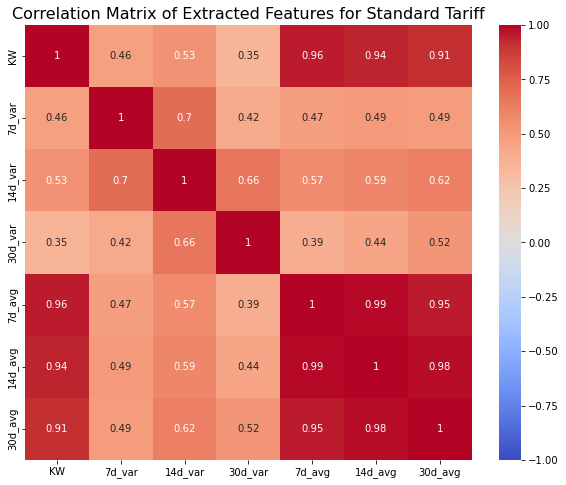

In [40]:
plt.figure(figsize = (10,8))
sns.heatmap(Std_df.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.title('Correlation Matrix of Extracted Features for Standard Tariff', fontsize = 16)
plt.show()

<AxesSubplot:>

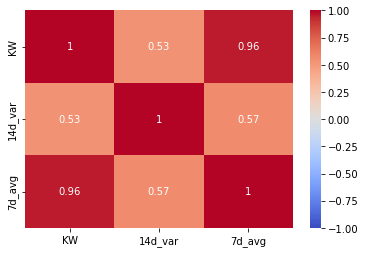

In [41]:
sns.heatmap((Std_df.drop(columns = ['14d_avg', '30d_avg', '30d_var', '7d_var'])).corr(), annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm')

- Fill NAs
- Moving avg
- Decompose
- Compare variance at different intervals